<a href="https://colab.research.google.com/github/87tana/Bone-Fracture-Detection-Model-with-YOLOv8/blob/main/Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Navigate to the project directory
%cd '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/'

# Define dataset path
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/Fraction_Detection_Dataset'

# Install necessary libraries
!pip install -q ultralytics torch torchvision opencv-python pillow matplotlib tqdm

Mounted at /content/drive/
/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection


In [2]:
# Import required libraries
import os
import cv2
import matplotlib.pyplot as plt

from ultralytics import YOLO

# Dataset Exploration and Validation

In [3]:
# -------------------- Train Dataset --------------------
print("\nExploring Train Dataset...")
train_images_dir = os.path.join(dataset_path, "train/images")  # Train images directory
train_labels_dir = os.path.join(dataset_path, "train/labels")  # Train labels directory

# List and sort train image and label files
train_image_files = sorted([f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.png'))])
train_label_files = sorted([f for f in os.listdir(train_labels_dir) if f.endswith('.txt')])


# Summary for train dataset
print(f"Total number of train images: {len(train_image_files)}")
print(f"Total number of train labels: {len(train_label_files)}")

if train_image_files and train_label_files:
    print(f"Sample train image file: {train_image_files[0]}")
    print(f"Sample train label file: {train_label_files[0]}")
else:
    print("Warning: Train dataset directories are empty!")

if len(train_image_files) != len(train_label_files):
    print("Warning: Train dataset - number of images and labels do not match!")
else:
    print("Train dataset is consistent.")


Exploring Train Dataset...
Total number of train images: 3779
Total number of train labels: 3779
Sample train image file: 0_wny3n8ot_jpg.rf.1f2df7789afda614056522ea95e81b49.jpg
Sample train label file: 0_wny3n8ot_jpg.rf.1f2df7789afda614056522ea95e81b49.txt
Train dataset is consistent.


In [4]:
# -------------------- Validation Dataset --------------------
print("\nExploring Validation Dataset...")
validation_images_dir = os.path.join(dataset_path, "valid/images")  # Corrected Validation images directory
validation_labels_dir = os.path.join(dataset_path, "valid/labels")  # Corrected Validation labels directory

# List and sort validation image and label files
validation_image_files = sorted([f for f in os.listdir(validation_images_dir) if f.endswith(('.jpg', '.png'))])
validation_label_files = sorted([f for f in os.listdir(validation_labels_dir) if f.endswith('.txt')])

# Summary for validation dataset
print(f"Total number of validation images: {len(validation_image_files)}")
print(f"Total number of validation labels: {len(validation_label_files)}")

if validation_image_files and validation_label_files:
    print(f"Sample validation image file: {validation_image_files[0]}")
    print(f"Sample validation label file: {validation_label_files[0]}")
else:
    print("Warning: Validation dataset directories are empty!")

if len(validation_image_files) != len(validation_label_files):
    print("Warning: Validation dataset - number of images and labels do not match!")
else:
    print("Validation dataset is consistent.")


Exploring Validation Dataset...
Total number of validation images: 835
Total number of validation labels: 835
Sample validation image file: bone-cancer_jpg.rf.639a15ed69b01b4dca593a1eb7062e1c.jpg
Sample validation label file: bone-cancer_jpg.rf.639a15ed69b01b4dca593a1eb7062e1c.txt
Validation dataset is consistent.


In [5]:
# -------------------- Test Dataset --------------------
print("\nExploring Test Dataset...")
test_images_dir = os.path.join(dataset_path, "test/images")  # Test images directory
test_labels_dir = os.path.join(dataset_path, "test/labels")  # Test labels directory

# List and sort test image and label files
test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png'))])
test_label_files = sorted([f for f in os.listdir(test_labels_dir) if f.endswith('.txt')])

# Summary for test dataset
print(f"Total number of test images: {len(test_image_files)}")
print(f"Total number of test labels: {len(test_label_files)}")

if test_image_files and test_label_files:
    print(f"Sample test image file: {test_image_files[0]}")
    print(f"Sample test label file: {test_label_files[0]}")
else:
    print("Warning: Test dataset directories are empty!")

if len(test_image_files) != len(test_label_files):
    print("Warning: Test dataset - number of images and labels do not match!")
else:
    print("Test dataset is consistent.")


Exploring Test Dataset...
Total number of test images: 841
Total number of test labels: 841
Sample test image file: Scanning-X-ray-Image-of-Lower-Leg-Bone_png.rf.1d4f4468fcb69c1d0fc474ebbbb5b278.jpg
Sample test label file: Scanning-X-ray-Image-of-Lower-Leg-Bone_png.rf.1d4f4468fcb69c1d0fc474ebbbb5b278.txt
Test dataset is consistent.


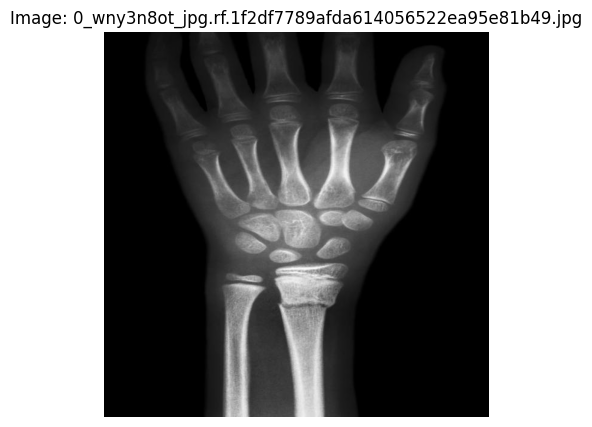

In [6]:
# Function to display an image
def show_image(image_path):
    """
    Display an image using Matplotlib.
    Args:
        image_path (str): Path to the image file.
    """
    image = cv2.imread(image_path)  # Load the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.show()

# Show the first image in the dataset
sample_image_path = os.path.join(train_images_dir,train_image_files[0])
show_image(sample_image_path)

## Converting the YOLO format bounding boxes from normalized coordinates to pixel values.

In [7]:
def load_yolo_annotations(txt_file, image_width, image_height):
    """
    Load YOLO annotations and convert them to pixel coordinates.
    Args:
        txt_file (str): Path to the YOLO `.txt` annotation file.
        image_width (int): Width of the image in pixels.
        image_height (int): Height of the image in pixels.
    Returns:
        List of bounding boxes in pixel coordinates.
        Each box: (class_id, x_min, y_min, width_pixel, height_pixel)
    """
    boxes = []
    with open(txt_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            class_id = int(data[0])  # Class ID (optional for now)
            x_center, y_center, width, height = map(float, data[1:])

            # Convert normalized YOLO coordinates to pixel coordinates
            x_center_pixel = int(x_center * image_width)
            y_center_pixel = int(y_center * image_height)
            width_pixel = int(width * image_width)
            height_pixel = int(height * image_height)

            # Calculate top-left corner
            x_min = int(x_center_pixel - width_pixel / 2)
            y_min = int(y_center_pixel - height_pixel / 2)
            boxes.append((class_id, x_min, y_min, width_pixel, height_pixel))
    return boxes


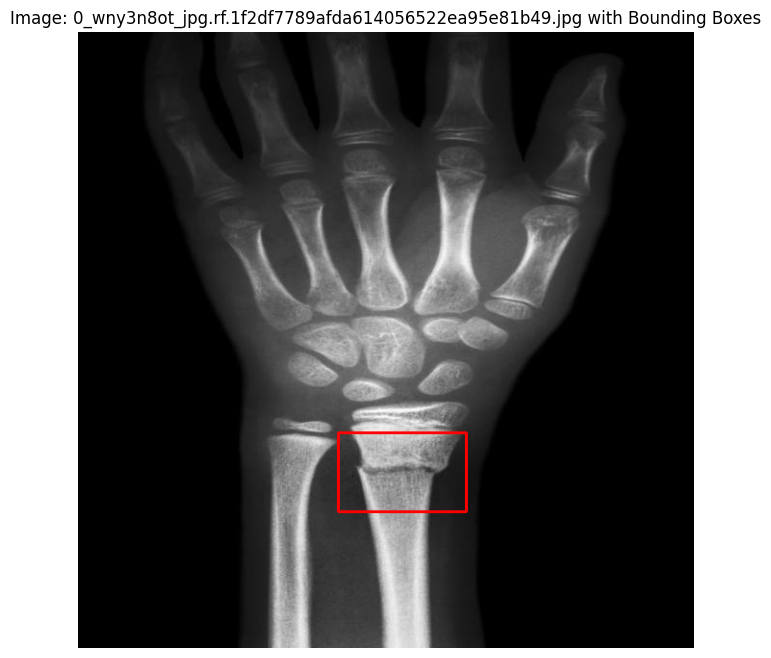

In [8]:
def visualize_image_with_boxes(train_images_dir, annotation_path):
    """
    Visualize an image with YOLOv8 bounding boxes.
    Args:
        image_path (str): Path to the image file.
        annotation_path (str): Path to the YOLO annotation file.
    """
    # Load image
    image = cv2.imread(train_images_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_height, image_width = image.shape[:2]

    # Load YOLO annotations
    boxes = load_yolo_annotations(annotation_path, image_width, image_height)

    # Draw bounding boxes on the image
    for box in boxes:
        class_id, x_min, y_min, width_pixel, height_pixel = box
        # Draw rectangle (bounding box)
        cv2.rectangle(image, (x_min, y_min), (x_min + width_pixel, y_min + height_pixel), color=(255, 0, 0), thickness=2)

    # Display the image with bounding boxes
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.title(f"Image: {os.path.basename(train_images_dir)} with Bounding Boxes")
    plt.show()

# Test the visualization with the first image and annotation
sample_image_path = os.path.join(train_images_dir, train_image_files[0])
sample_label_path = os.path.join(train_labels_dir, os.path.splitext(train_image_files[0])[0] + '.txt')
visualize_image_with_boxes(sample_image_path, sample_label_path)

## Number of bounding box:



In [19]:
def count_bounding_boxes(txt_file):
    """
    Count how many bounding boxes exist in the given YOLO annotation file.
    Args:
        txt_file (str): Path to the YOLO `.txt` annotation file.
    Returns:
        int: Number of bounding boxes in the image.
    """
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    return len(lines)

# Example usage for counting bounding boxes in the first image
sample_label_path = os.path.join(train_labels_dir, os.path.splitext(train_image_files[0])[0] + '.txt')
num_boxes = count_bounding_boxes(sample_label_path)
print(f"Number of bounding boxes in image {train_image_files[0]}: {num_boxes}")

Number of bounding boxes in image 0_wny3n8ot_jpg.rf.1f2df7789afda614056522ea95e81b49.jpg: 1


In [23]:
def count_bounding_boxes(txt_file):
    """
    Count how many bounding boxes exist in the given YOLO annotation file.
    Args:
        txt_file (str): Path to the YOLO `.txt` annotation file.
    Returns:
        int: Number of bounding boxes in the image.
    """
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    return len(lines)

# Example usage for counting bounding boxes in the first image
sample_label_path = os.path.join(train_labels_dir, os.path.splitext(train_image_files[100])[0] + '.txt')
num_boxes = count_bounding_boxes(sample_label_path)
print(f"Number of bounding boxes in image {train_image_files[100]}: {num_boxes}")

Number of bounding boxes in image finger_open_jpg.rf.41cc0fb703d54d57d049fe323601b54f.jpg: 3


## check the bounding box of the first image in the training set

In [26]:
# Function to load YOLO annotations and calculate bounding box sizes
def get_bounding_box_sizes(txt_file, image_width, image_height):
    """
    Extract and calculate the size of each bounding box from a YOLO annotation file.
    Args:
        txt_file (str): Path to the YOLO `.txt` annotation file.
        image_width (int): Width of the image in pixels.
        image_height (int): Height of the image in pixels.
    Returns:
        list: List of bounding box sizes in pixels (width x height).
    """
    bounding_box_sizes = []
    with open(txt_file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        data = line.strip().split()
        # YOLO annotation format: class_id, x_center, y_center, width, height
        x_center, y_center, width, height = map(float, data[1:])

        # Convert YOLO coordinates to pixel values
        width_pixel = int(width * image_width)
        height_pixel = int(height * image_height)

        # Append the size (width * height) to the list
        bounding_box_sizes.append((width_pixel, height_pixel))

    return bounding_box_sizes

# Get the first image and label path
sample_label_path = os.path.join(train_labels_dir, os.path.splitext(train_image_files[0])[0] + '.txt')

# Load the first image to get its width and height
sample_image_path = os.path.join(train_images_dir, train_image_files[0])
image = cv2.imread(sample_image_path)
image_height, image_width = image.shape[:2]

# Get the bounding box sizes
bounding_box_sizes = get_bounding_box_sizes(sample_label_path, image_width, image_height)

# Print the bounding box sizes for the first image
print(f"Bounding box sizes (width x height) for the first image {train_image_files[0]}:")
for size in bounding_box_sizes:
    print(f"Width: {size[0]} px, Height: {size[1]} px")


Bounding box sizes (width x height) for the first image 0_wny3n8ot_jpg.rf.1f2df7789afda614056522ea95e81b49.jpg:
Width: 133 px, Height: 82 px
